In [1]:
import georasters as gr

import pandas as pd
import geopandas as gpd

from osgeo import osr, gdal

import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/Users/farahayyad/Desktop/SLR-Research/Week-5'

In [3]:
elevation_t = gr.from_file('Data/Elevation.TIF')
elevation_df = elevation_t.to_pandas()

vlm_d = pd.read_excel('Data/data_analisis.xls')
slr_d = pd.read_excel('Data/SLR-A.xls', skiprows=15)

In [4]:
slr_d.head()

,Site,PSMSL ID,Latitude,Longitude,Scenario,Background RSL rate (mm/yr),RSL in 2000 (cm),RSL in 2010 (cm),RSL in 2020 (cm),RSL in 2030 (cm),RSL in 2040 (cm),RSL in 2050 (cm),RSL in 2060 (cm),RSL in 2070 (cm),RSL in 2080 (cm),RSL in 2090 (cm),RSL in 2100 (cm),RSL in 2120 (cm),RSL in 2150 (cm),RSL in 2200 (cm)
0,NEW YORK,12,54.080777,23.8926,0.3 - MED,1.29,0,5,11,15,20,25,31,36,39,44,46,51,58,69
1,NEW YORK,12,54.080777,23.8926,0.3 - LOW,1.20,0,2,6,10,13,15,18,19,21,21,22,27,28,26
2,NEW YORK,12,54.080777,23.8926,0.3 - HIGH,1.38,0,7,14,21,28,36,42,49,54,60,65,75,88,110
3,NEW YORK,12,54.080777,23.8926,0.5 - MED,1.29,0,6,13,19,25,31,39,45,50,56,61,70,85,110
4,NEW YORK,12,54.080777,23.8926,0.5 - LOW,1.20,0,4,8,13,18,24,29,33,39,43,47,54,63,70


In [5]:
vlm_d.head()

,Station,Longitude,Latitude,VLM,VLM_std
0,NYWV,54.684594,24.796595,-0.207,0.223
1,NYWT,54.115618,24.303783,1.413,0.158
2,NYSM,53.848164,24.056855,-0.856,0.154
3,NYRH,53.141386,24.147625,-0.724,0.166
4,NYRB,52.587928,24.171598,1.812,0.274


Convert Excel File to Shapefile

In [6]:
import fiona
import pandas as pd
from collections import OrderedDict

In [7]:
totalColi = pd.read_excel('Data/data_analisis.xls', index_col=0)
totalColi.head()

,Longitude,Latitude,VLM,VLM_std
Station,,,,
NYWV,54.684594,24.796595,-0.207,0.223
NYWT,54.115618,24.303783,1.413,0.158
NYSM,53.848164,24.056855,-0.856,0.154
NYRH,53.141386,24.147625,-0.724,0.166
NYRB,52.587928,24.171598,1.812,0.274


In [8]:
totalColi.dtypes

Longitude    float64
Latitude     float64
VLM          float64
VLM_std      float64
dtype: object

In [9]:
schema = {'properties': OrderedDict([('obsName', 'str')]), 'geometry': 'Point'}
crs = {'init': 'epsg:4326'}

In [10]:
coliShp = fiona.open('Data/totalColiforms.shp',mode='w',schema=schema,driver='ESRI Shapefile',crs=crs)

for index, line in totalColi.iterrows():
    feature = {
    'geometry':{'type':'Point','coordinates':(line.Longitude,line.Latitude)},
    'properties':OrderedDict([('obsName',index)])
    }
    coliShp.write(feature)
coliShp.close()

Extracting Point Values from Shapefile

epsg:4326


<AxesSubplot:>

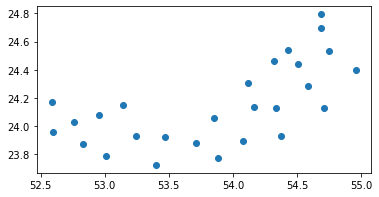

In [11]:
#open point shapefile
vlm_point = gpd.read_file('Data/totalColiforms.shp')
print(vlm_point.crs)
vlm_point.plot()

Extracting Point Values from Raster

In [12]:
elevation_raster = rasterio.open('Data/Elevation.tif')
print(elevation_raster.crs)
print(elevation_raster.count)

EPSG:4326
1


Show point and raster on a matplotlib plot

In [13]:
min_latitude, min_longitude = min(vlm_d.Latitude), min(vlm_d.Longitude)
max_latitude, max_longitude = max(vlm_d.Latitude), max(vlm_d.Longitude)

<ipython-input-14-bc2133a4affd>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


<AxesSubplot:>

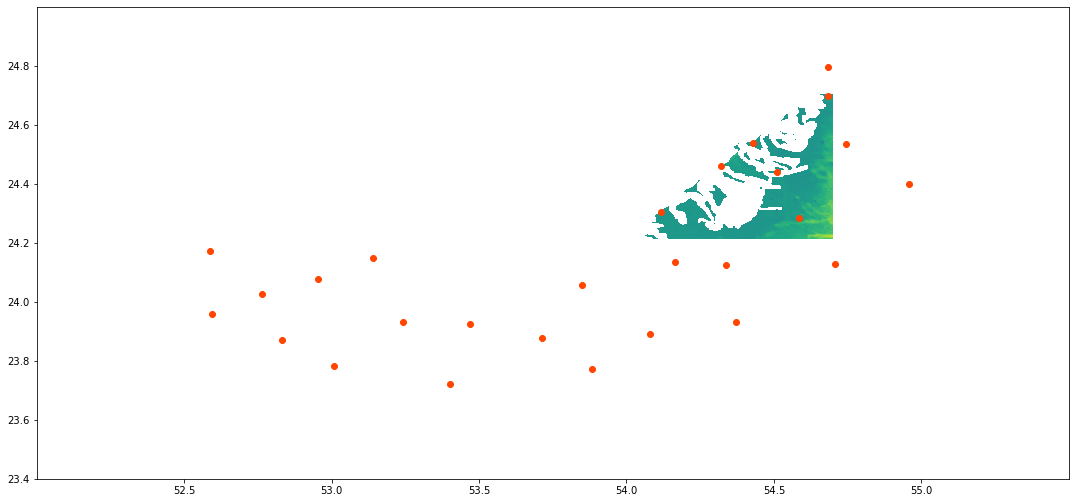

In [14]:
#show point and raster on a matplotlib plot
from rasterio.plot import show
from matplotlib.pyplot import gcf

plt.axes()
plt.xlim([52, 55.5])
plt.ylim([23.4, 25])
plt.xticks(np.arange(52.5, 55.5, 0.5))
plt.yticks(np.arange(23.4, 24.8, 0.2))
ax = plt.axes()

fig = gcf()
fig.set_size_inches(18.5, 10.5)

vlm_point.plot(ax=ax, color='orangered')
show(elevation_raster, ax=ax)

<AxesSubplot:>

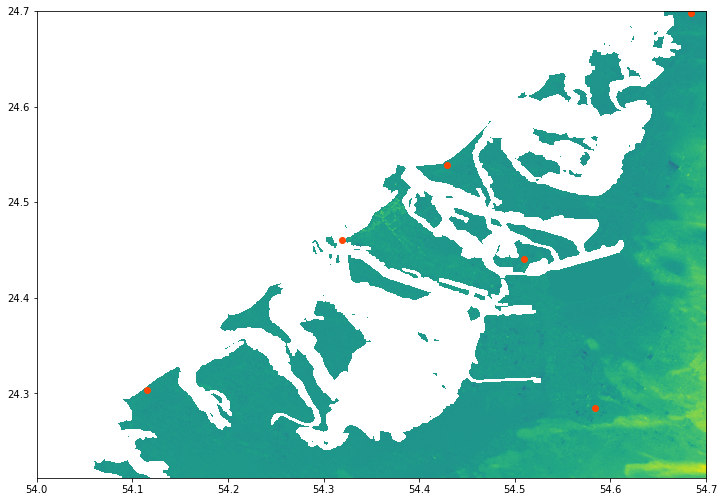

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
vlm_point.plot(ax=ax, color='orangered')
show(elevation_raster, ax=ax)

# Interpolation-1

In [16]:
grid_x, grid_y = np.mgrid[min_longitude:max_longitude:100j, min_latitude:max_latitude:200j]

In [17]:
vlm_points = vlm_d[['Longitude', 'Latitude']].values
vlm_values = vlm_d.VLM.values

In [18]:
from scipy.interpolate import griddata

grid_z0 = griddata(vlm_points, vlm_values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(vlm_points, vlm_values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(vlm_points, vlm_values, (grid_x, grid_y), method='cubic')

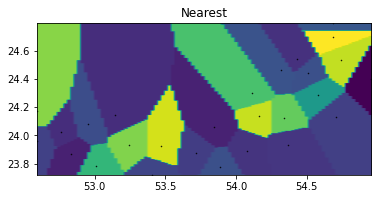

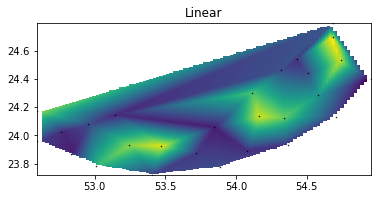

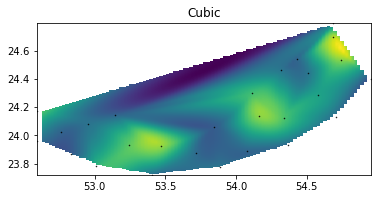

In [19]:
import matplotlib.pyplot as plt

plt.imshow(grid_z0.T, extent=(min_longitude, max_longitude, min_latitude, max_latitude), origin='lower')
plt.plot(vlm_points[:,0], vlm_points[:,1], 'k.', ms=1)
plt.title('Nearest')
plt.show()

l = plt.imshow(grid_z1.T, extent=(min_longitude, max_longitude, min_latitude, max_latitude), origin='lower')
plt.plot(vlm_points[:,0], vlm_points[:,1], 'k.', ms=1)
plt.title('Linear')
plt.show()

plt.imshow(grid_z2.T, extent=(min_longitude, max_longitude, min_latitude, max_latitude), origin='lower')
plt.plot(vlm_points[:,0], vlm_points[:,1], 'k.', ms=1)
plt.title('Cubic')
plt.show()

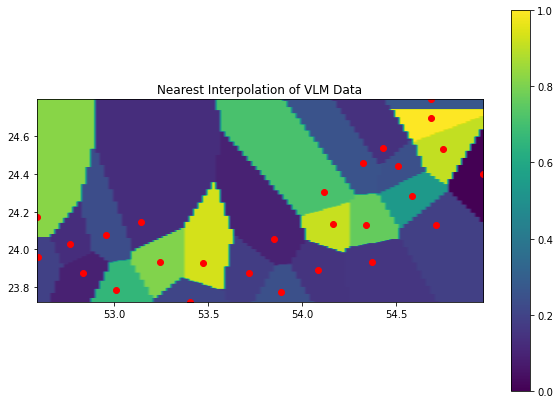

In [20]:
plt.imshow(grid_z0.T, extent=(min_longitude, max_longitude, min_latitude, max_latitude), origin='lower')

plt.scatter(vlm_d.Longitude, vlm_d.Latitude, color='r')

fig = gcf()
fig.set_size_inches(10, 7)



plt.title('Nearest Interpolation of VLM Data')
plt.colorbar()
plt.show()

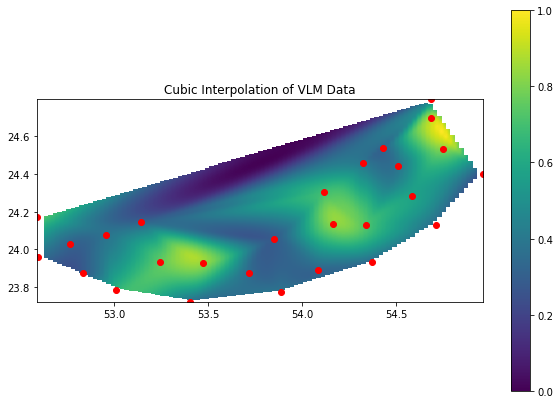

In [21]:
plt.imshow(grid_z2.T, extent=(min_longitude, max_longitude, min_latitude, max_latitude), origin='lower')

plt.scatter(vlm_d.Longitude, vlm_d.Latitude, color='r')

fig = gcf()
fig.set_size_inches(10, 7)



plt.title('Cubic Interpolation of VLM Data')
plt.colorbar()
plt.show()

# Interpolation-2

Work with shapefiles

In [22]:
sh_f = gpd.read_file('Data/totalColiforms.shp')

In [23]:
totalPointsArray = np.zeros([sh_f.shape[0],2])
#iteration over the geopandas dataframe
for index, point in sh_f.iterrows():
    pointArray = np.array([point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0]])
    totalPointsArray[index] = pointArray
totalPointsArray[:5,:]

array([[54.684594, 24.796595],
       [54.115618, 24.303783],
       [53.848164, 24.056855],
       [53.141386, 24.147625],
       [52.587928, 24.171598]])

In [24]:
from matplotlib.tri import Triangulation, LinearTriInterpolator

#triangulation function
triFn = Triangulation(totalPointsArray[:,0],totalPointsArray[:,1])
#linear triangule interpolator funtion
linTriFn = LinearTriInterpolator(triFn,totalPointsArray[:,1])

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


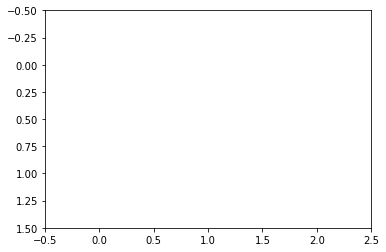

In [25]:
rasterRes = 2

xCoords = np.arange(totalPointsArray[:,0].min(), totalPointsArray[:,0].max()+rasterRes, rasterRes)
yCoords = np.arange(totalPointsArray[:,1].min(), totalPointsArray[:,1].max()+rasterRes, rasterRes)
zCoords = np.zeros([yCoords.shape[0],xCoords.shape[0]])

#loop among each cell in the raster extension
for indexX, x in np.ndenumerate(xCoords):
    for indexY, y in np.ndenumerate(yCoords):
        tempZ = linTriFn(x,y)
        #filtering masked values
        if tempZ == tempZ:
            zCoords[indexY,indexX]=tempZ
        else:
            zCoords[indexY,indexX]=np.nan

#preliminary representation of the interpolated values
plt.imshow(zCoords)

# Calculating AE = Elevation - RSL + VLM 

In [26]:
slr_d.head()

,Site,PSMSL ID,Latitude,Longitude,Scenario,Background RSL rate (mm/yr),RSL in 2000 (cm),RSL in 2010 (cm),RSL in 2020 (cm),RSL in 2030 (cm),RSL in 2040 (cm),RSL in 2050 (cm),RSL in 2060 (cm),RSL in 2070 (cm),RSL in 2080 (cm),RSL in 2090 (cm),RSL in 2100 (cm),RSL in 2120 (cm),RSL in 2150 (cm),RSL in 2200 (cm)
0,NEW YORK,12,54.080777,23.8926,0.3 - MED,1.29,0,5,11,15,20,25,31,36,39,44,46,51,58,69
1,NEW YORK,12,54.080777,23.8926,0.3 - LOW,1.20,0,2,6,10,13,15,18,19,21,21,22,27,28,26
2,NEW YORK,12,54.080777,23.8926,0.3 - HIGH,1.38,0,7,14,21,28,36,42,49,54,60,65,75,88,110
3,NEW YORK,12,54.080777,23.8926,0.5 - MED,1.29,0,6,13,19,25,31,39,45,50,56,61,70,85,110
4,NEW YORK,12,54.080777,23.8926,0.5 - LOW,1.20,0,4,8,13,18,24,29,33,39,43,47,54,63,70


In [27]:
slr_d_new = slr_d[['Latitude', 'Longitude', 'Scenario', 'Background RSL rate (mm/yr)', 'RSL in 2030 (cm)'
              , 'RSL in 2050 (cm)', 'RSL in 2080 (cm)', 'RSL in 2100 (cm)']]
slr_d_new.head()

,Latitude,Longitude,Scenario,Background RSL rate (mm/yr),RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm)
0,54.080777,23.8926,0.3 - MED,1.29,15,25,39,46
1,54.080777,23.8926,0.3 - LOW,1.20,10,15,21,22
2,54.080777,23.8926,0.3 - HIGH,1.38,21,36,54,65
3,54.080777,23.8926,0.5 - MED,1.29,19,31,50,61
4,54.080777,23.8926,0.5 - LOW,1.20,13,24,39,47


AE for the years 2030, 2050, 2080, 2100

In [28]:
elevation_df

,row,col,value,x,y
0,0,2347,1.0,54.651806,24.700139
1,0,2348,0.0,54.652084,24.700139
2,0,2349,1.0,54.652361,24.700139
3,0,2350,1.0,54.652639,24.700139
4,0,2351,2.0,54.652917,24.700139
...,...,...,...,...,...
1789656,1757,2516,37.0,54.698750,24.212083
1789657,1757,2517,36.0,54.699028,24.212083
1789658,1757,2518,37.0,54.699306,24.212083
1789659,1757,2519,38.0,54.699584,24.212083


In [29]:
coordinates = elevation_df[['x', 'y']].values
coordinates

array([[54.65180585, 24.70013871],
       [54.65208362, 24.70013871],
       [54.6523614 , 24.70013871],
       ...,
       [54.69930585, 24.21208311],
       [54.69958363, 24.21208311],
       [54.69986141, 24.21208311]])

In [30]:
grid_z0 = griddata(vlm_points, vlm_values, coordinates, method='nearest')

In [31]:
d = [2030, 2050, 2080, 2100]

ae_calculations = pd.DataFrame()
ae_calculations['Elevation Values'] = elevation_df['value']
ae_calculations['Longitude'] = elevation_df['x']
ae_calculations['Latitude'] = elevation_df['y']
ae_calculations['VLM'] = grid_z0
ae_calculations

,Elevation Values,Longitude,Latitude,VLM
0,1.0,54.651806,24.700139,2.471
1,0.0,54.652084,24.700139,2.471
2,1.0,54.652361,24.700139,2.471
3,1.0,54.652639,24.700139,2.471
4,2.0,54.652917,24.700139,2.471
...,...,...,...,...
1789656,37.0,54.698750,24.212083,-0.510
1789657,36.0,54.699028,24.212083,-0.510
1789658,37.0,54.699306,24.212083,-0.510
1789659,38.0,54.699584,24.212083,-0.510


In [32]:
for i in d:
    AE = ae_calculations['Elevation Values'] + ae_calculations['VLM'] - slr_d_new['RSL in ' +str(i)+ ' (cm)'].loc[0]
    ae_calculations['AE in ' + str(i)] = ""
    ae_calculations['AE in ' + str(i)] = AE

In [33]:
ae_calculations

,Elevation Values,Longitude,Latitude,VLM,AE in 2030,AE in 2050,AE in 2080,AE in 2100
0,1.0,54.651806,24.700139,2.471,-11.529,-21.529,-35.529,-42.529
1,0.0,54.652084,24.700139,2.471,-12.529,-22.529,-36.529,-43.529
2,1.0,54.652361,24.700139,2.471,-11.529,-21.529,-35.529,-42.529
3,1.0,54.652639,24.700139,2.471,-11.529,-21.529,-35.529,-42.529
4,2.0,54.652917,24.700139,2.471,-10.529,-20.529,-34.529,-41.529
...,...,...,...,...,...,...,...,...
1789656,37.0,54.698750,24.212083,-0.510,21.490,11.490,-2.510,-9.510
1789657,36.0,54.699028,24.212083,-0.510,20.490,10.490,-3.510,-10.510
1789658,37.0,54.699306,24.212083,-0.510,21.490,11.490,-2.510,-9.510
1789659,38.0,54.699584,24.212083,-0.510,22.490,12.490,-1.510,-8.510


In [34]:
len(ae_calculations)

1789661

In [35]:
grid_z0

array([ 2.471,  2.471,  2.471, ..., -0.51 , -0.51 , -0.51 ])

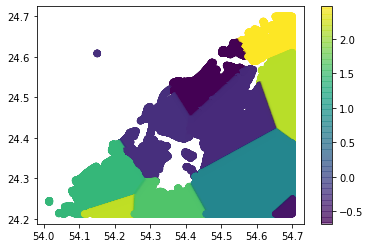

In [36]:
plt.scatter(ae_calculations.Longitude, ae_calculations.Latitude, alpha=0.5, c=grid_z0)
plt.colorbar()

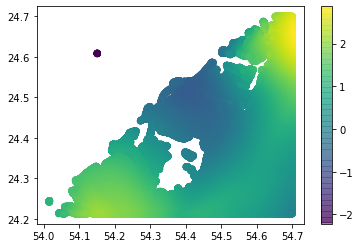

In [37]:
grid_z2 = griddata(vlm_points, vlm_values, coordinates, method='cubic')
plt.scatter(ae_calculations.Longitude, ae_calculations.Latitude, alpha=0.5, c=grid_z2)
plt.colorbar()

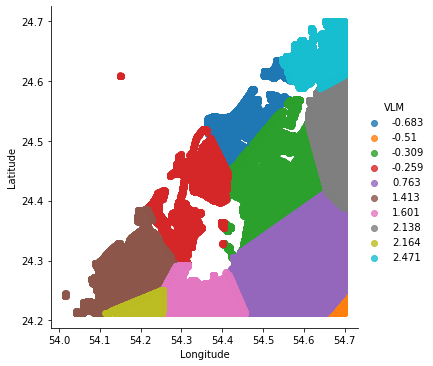

In [38]:
import seaborn as sns
sns.lmplot(x='Longitude', y='Latitude', data = ae_calculations, hue='VLM' , fit_reg=False)

# Plotting AEs

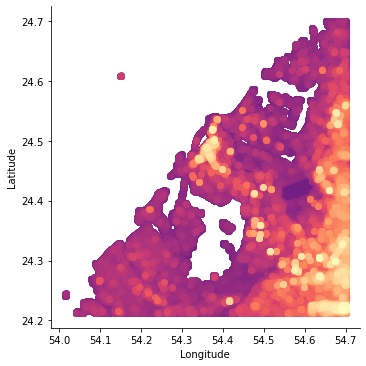

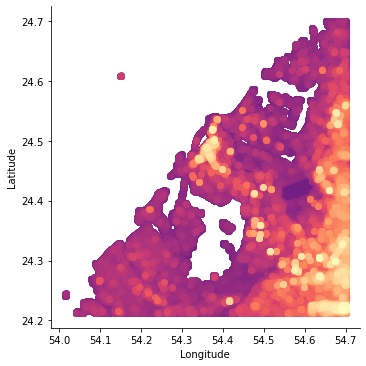

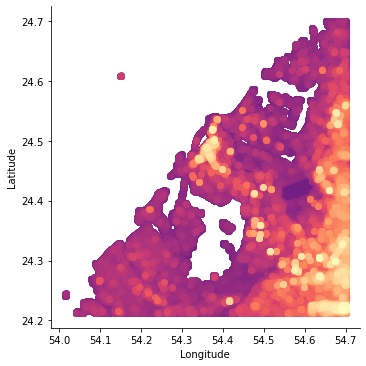

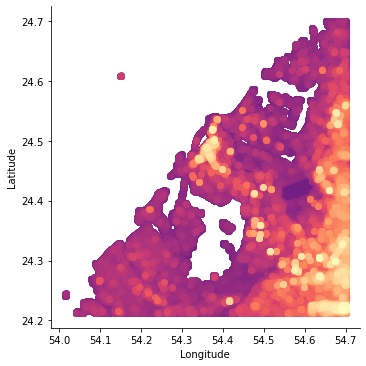

In [39]:
sns.lmplot(x='Longitude', y='Latitude', data = ae_calculations, hue='AE in 2030', palette="magma", fit_reg=False, legend=False)

sns.lmplot(x='Longitude', y='Latitude', data = ae_calculations, hue='AE in 2050', palette="magma", fit_reg=False, legend=False)

sns.lmplot(x='Longitude', y='Latitude', data = ae_calculations, hue='AE in 2080', palette="magma", fit_reg=False, legend=False)

sns.lmplot(x='Longitude', y='Latitude', data = ae_calculations, hue='AE in 2100', palette="magma", fit_reg=False, legend=False)

# Scenarios

In [40]:
scenarios_df = pd.DataFrame()

d = slr_d_new.iloc[1]
scenarios_df = scenarios_df.append(d, ignore_index=True)

d = slr_d_new.iloc[17]
scenarios_df = scenarios_df.append(d, ignore_index=True)

scenarios_df['Elevation_Values'] = elevation_df['value']

scenarios_df['VLM'] = ""
scenarios_df['VLM'].iloc[0] = ae_calculations['VLM'].iloc[1]
scenarios_df['VLM'].iloc[1] = ae_calculations['VLM'].iloc[17]

scenarios_df

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Background RSL rate (mm/yr),Latitude,Longitude,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm),Scenario,Elevation_Values,VLM
0,1.20,54.080777,23.8926,10.0,15.0,21.0,22.0,0.3 - LOW,1.0,2.471
1,1.38,54.080777,23.8926,55.0,114.0,241.0,357.0,2.5 - HIGH,0.0,2.471


In [41]:
scenarios_df['RSL_Sum'] = scenarios_df['RSL in 2030 (cm)'] + scenarios_df['RSL in 2050 (cm)'] + scenarios_df['RSL in 2080 (cm)'] + scenarios_df['RSL in 2100 (cm)']
scenarios_df

,Background RSL rate (mm/yr),Latitude,Longitude,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm),Scenario,Elevation_Values,VLM,RSL_Sum
0,1.20,54.080777,23.8926,10.0,15.0,21.0,22.0,0.3 - LOW,1.0,2.471,68.0
1,1.38,54.080777,23.8926,55.0,114.0,241.0,357.0,2.5 - HIGH,0.0,2.471,767.0


In [42]:
scenarios_df['AE'] = scenarios_df['Elevation_Values'] + scenarios_df['VLM'] - scenarios_df['RSL_Sum']

In [43]:
scenarios_df

,Background RSL rate (mm/yr),Latitude,Longitude,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm),Scenario,Elevation_Values,VLM,RSL_Sum,AE
0,1.20,54.080777,23.8926,10.0,15.0,21.0,22.0,0.3 - LOW,1.0,2.471,68.0,-64.529
1,1.38,54.080777,23.8926,55.0,114.0,241.0,357.0,2.5 - HIGH,0.0,2.471,767.0,-764.529
